# AK For

In [1]:
%matplotlib inline

In [2]:
#%run notebook_setup

"""isort:skip_file"""

get_ipython().magic('config InlineBackend.figure_format = "retina"')

import os
import logging
import warnings

import matplotlib.pyplot as plt

# Don't use the schmantzy progress bar
os.environ["EXOPLANET_NO_AUTO_PBAR"] = "true"

# Remove when Theano is updated
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Remove when arviz is updated
warnings.filterwarnings("ignore", category=UserWarning)


logger = logging.getLogger("theano.gof.compilelock")
logger.setLevel(logging.ERROR)
logger = logging.getLogger("exoplanet")
logger.setLevel(logging.DEBUG)


plt.style.use("default")
plt.rcParams["savefig.dpi"] = 100
plt.rcParams["figure.dpi"] = 100
plt.rcParams["font.size"] = 16
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Liberation Sans"]
plt.rcParams["font.cursive"] = ["Liberation Sans"]
plt.rcParams["mathtext.fontset"] = "custom"

# Fitting a detached eclipsing binary

In this case study, we'll go through the steps required to fit the light curve and radial velocity measurements for the detached eclipsing binary system HD 23642.
This is a bright system that has been fit by many authors ([1](https://arxiv.org/abs/astro-ph/0403444), [2](https://arxiv.org/abs/astro-ph/0409507), [3](https://ui.adsabs.harvard.edu/abs/2007A%26A...463..579G/abstract), [4](https://arxiv.org/abs/1602.01901), and [5](https://arxiv.org/abs/1603.08484) to name a few) so this is a good benchmark for our demonstration.

The light curve that we'll use is from K2 and we'll use the same radial velocity measurements as [David+ (2016)](https://arxiv.org/abs/1602.01901) compiled from [here](https://arxiv.org/abs/astro-ph/0403444) and [here](https://ui.adsabs.harvard.edu/abs/2007A%26A...463..579G/abstract).
We'll use a somewhat simplified model for the eclipses that treats the stars as spherical and ignores the phase curve (we'll model it using a Gaussian process instead of a more physically motivated model).
But, as you'll see, these simplifying assumptions are sufficient for this case of a detached and well behaved system.
Unlike some previous studies, we will fit an eccentric orbit instead of fixing the eccentricity to zero.
This probably isn't really necessary here, but it's useful to demonstrate how you would fit a more eccentric system.
Finally, we model the phase curve and other triends in both the light curve and radial velocities using Gaussian processes.
This will account for unmodeled stellar variability and residual systematics, drifts, and other effects left over from the data reduction procedure.

## Data access

First, let's define some values from the literature that will be useful below.
Here we're taking the period and eclipse time from [David+ (2016)](https://arxiv.org/abs/1602.01901) as initial guesses for these parameters in our fit.
We'll also include the same prior on the flux ratio of the two stars that was computed for the Kepler bandpass by [David+ (2016)](https://arxiv.org/abs/1602.01901).

In [3]:
lit_period = 3.9809913 #days
lit_t0 = 2451903.2681 - 2457000

# Prior on the flux ratio for Kepler
lit_flux_ratio = (0.423, 0.1) 

Then we'll download the Kepler data.
In this case, the pipeline aperture photometry isn't very good (because this star is so bright!) so we'll just download the target pixel file and co-add all the pixels.

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


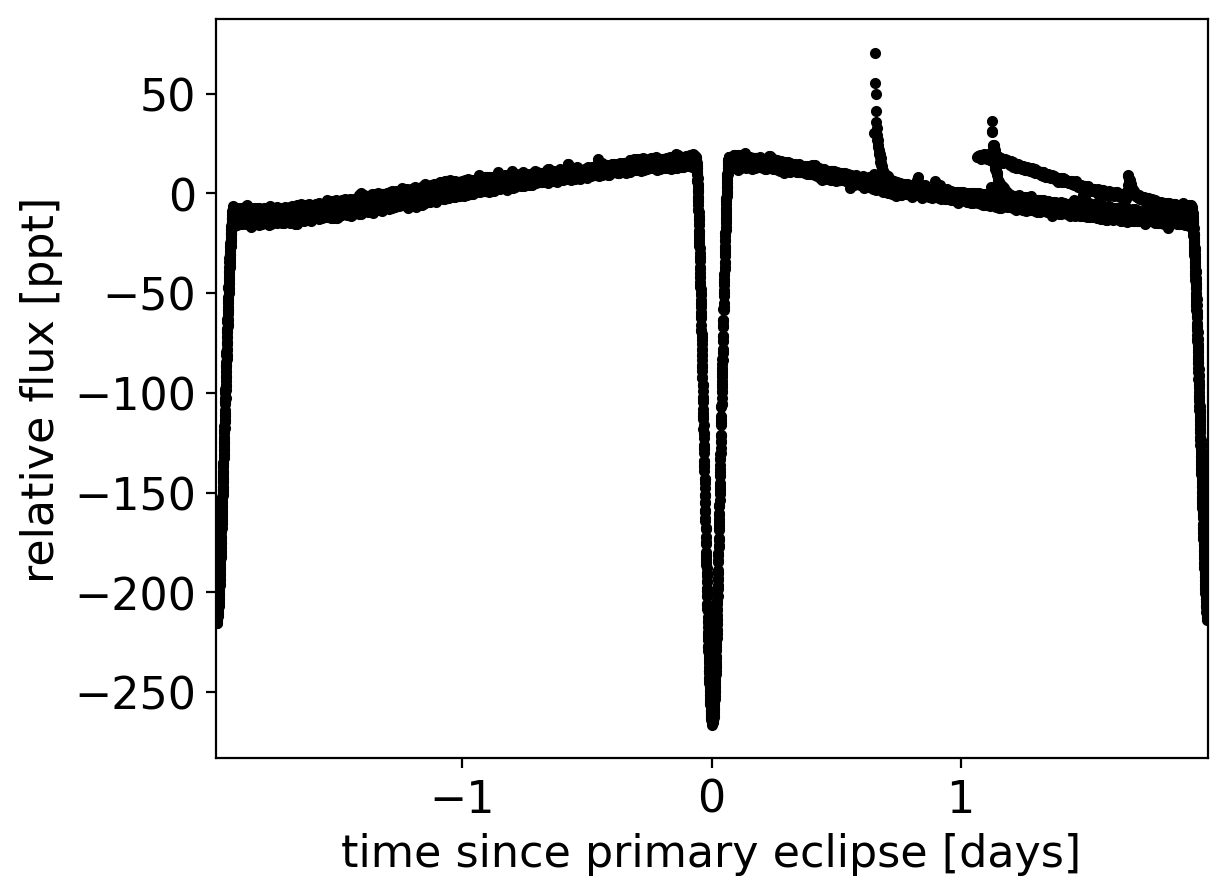

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk

tpf = lk.search_targetpixelfile("AK Fornacis", mission=('TESS')).download() #TIC ID
lc = tpf.to_lightcurve(aperture_mask="all") 
lc = lc.remove_nans().normalize()

lc_clean = lc.remove_outliers(sigma=10)       

hdr = tpf.hdu[1].header
texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

# x = np.ascontiguousarray(lc.time, dtype=np.float64)
# y = np.ascontiguousarray(lc.flux, dtype=np.float64)
x = np.ascontiguousarray(lc_clean.time, dtype=np.float64)
y = np.ascontiguousarray(lc_clean.flux, dtype=np.float64)
mu = np.median(y)
y = (y / mu - 1) * 1e3

plt.plot((x - lit_t0 + 0.5 * lit_period) % lit_period - 0.5 * lit_period, y, ".k")
plt.xlim(-0.5 * lit_period, 0.5 * lit_period)
plt.xlabel("time since primary eclipse [days]")
_ = plt.ylabel("relative flux [ppt]")

plt.show()

Then we'll enter the radial velocity data.
I couldn't find these data online anywhere so I manually transcribed the data from the referenced papers (typos are my own!).

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


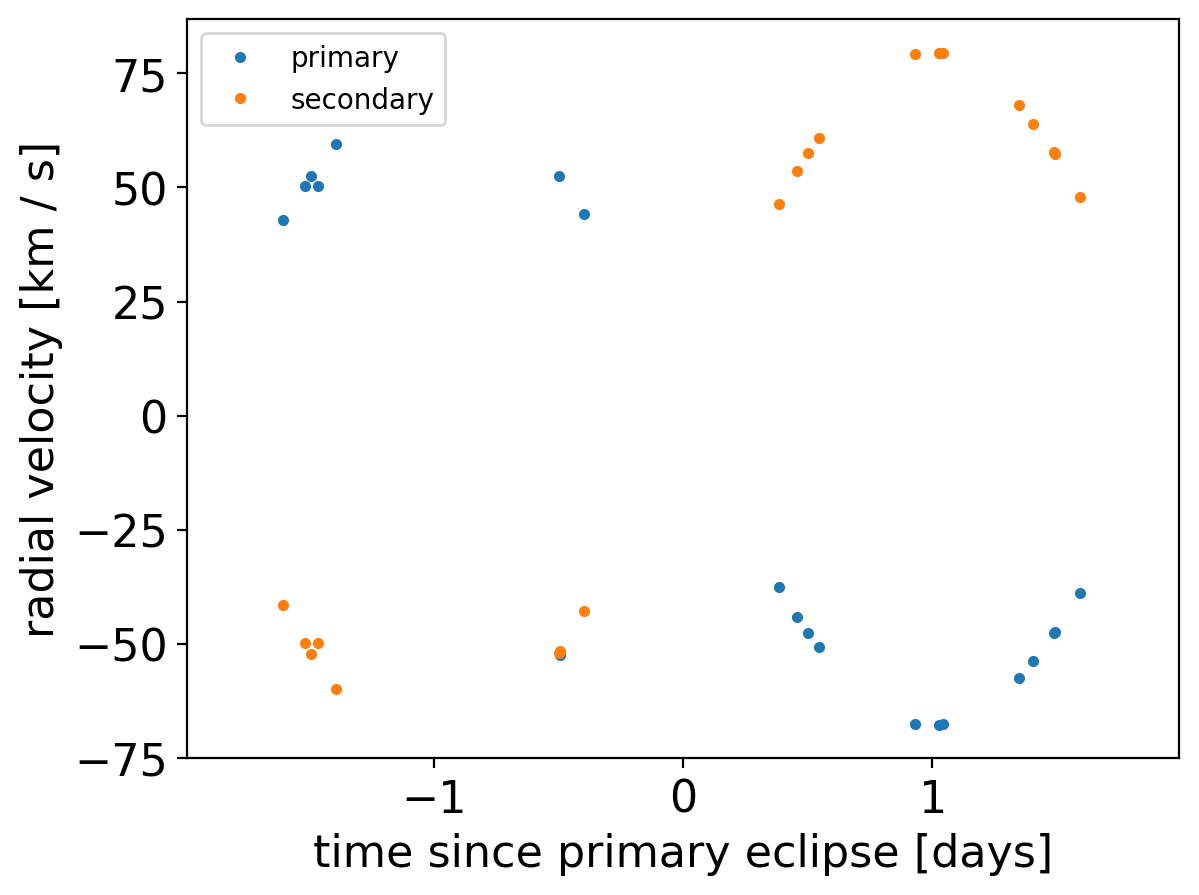

In [5]:
ref_date = 2450000
rvs = np.array(
    [
        (5876.681435 + ref_date, -37.483, 46.441), #(HJD, RV_primary, RV_secondary)
        (5876.841349 + ref_date, -50.637, 60.928),
        (5877.644573 + ref_date, -57.370, 67.959),
        (5877.701489 + ref_date, -53.645, 64.000),
        
        (5877.783808 + ref_date, -47.668, 57.725),
        (5878.673272 + ref_date, 42.913, -41.535),
        (5878.759453 + ref_date, 50.399, -49.798),
        (5878.810493 + ref_date, 50.399, -49.798),
        
        (6179.782690 + ref_date, -67.426, 79.214),
        (6179.879929 + ref_date, -67.687, 79.484),
        (6195.817064 + ref_date, -67.545, 79.397),
        (6345.559577 + ref_date, -52.316, -51.594),
        
        (6346.511053 + ref_date, -44.029, 53.513),
        (6347.545693 + ref_date, -47.323, 57.305),
        (6348.542794 + ref_date, 52.439, -52.171),
        (6349.537454 + ref_date, 52.613, -51.882),
        
        (6350.536805 + ref_date, -47.586, 57.613),
        (6376.509645 + ref_date, 59.529, -59.889),
        (6377.503283 + ref_date, 44.095, -42.758),
        (6383.474455 + ref_date, -38.866, 47.980),
    ]
)
rvs[:,0] -= 2457000
rvs = rvs[np.argsort(rvs[:, 0])]

x_rv = np.ascontiguousarray(rvs[:, 0], dtype=np.float64)
y1_rv = np.ascontiguousarray(rvs[:, 1], dtype=np.float64)
y2_rv = np.ascontiguousarray(rvs[:, 2], dtype=np.float64)

fold = (rvs[:, 0] - lit_t0 + 0.5 * lit_period) % lit_period - 0.5 * lit_period
plt.plot(fold, rvs[:, 1], ".", label="primary")
plt.plot(fold, rvs[:, 2], ".", label="secondary")
plt.legend(fontsize=10)
plt.xlim(-0.5 * lit_period, 0.5 * lit_period)
plt.ylabel("radial velocity [km / s]")
_ = plt.xlabel("time since primary eclipse [days]")

#plt.show()

## Probabilistic model

Then we define the probabilistic model using PyMC3 and exoplanet.
This is similar to the other tutorials and case studies, but here we're using a :class:`exoplanet.SecondaryEclipseLightCurve` to generate the model light curve and we're modeling the radial velocity trends using a Gaussian process instead of a polynomial.
Otherwise, things should look pretty familiar!

After defining the model, we iteratively clip outliers in the light curve using sigma clipping and then estimate the maximum a posteriori parameters.

In [6]:
import multiprocessing as mp
mp.set_start_method("fork")

In [7]:
# import theano
# theano.config.gcc.cxxflags = "-Wno-c++11-narrowing" 

In [8]:
import pymc3 as pm
import theano.tensor as tt

import exoplanet as xo


def build_model(mask):

    with pm.Model() as model:

        # Systemic parameters
        mean_lc = pm.Normal("mean_lc", mu=0.0, sd=5.0)
        mean_rv = pm.Normal("mean_rv", mu=0.0, sd=50.0)
        u1 = xo.QuadLimbDark("u1")
        u2 = xo.QuadLimbDark("u2")

        # Parameters describing the primary
        M1 = pm.Lognormal("M1", mu=0.0, sigma=10.0, testval=0.696)
        R1 = pm.Lognormal("R1", mu=0.0, sigma=10.0, testval=0.687)

        # Secondary ratios
        k = pm.Lognormal("k", mu=0.0, sigma=10.0, testval=0.9403)  # radius ratio
        q = pm.Lognormal("q", mu=0.0, sigma=10.0, testval=0.9815)  # mass ratio
        s = pm.Lognormal("s", mu=np.log(0.5), sigma=10.0)  # surface brightness ratio

        # Prior on flux ratio
        pm.Normal(
            "flux_prior",
            mu=lit_flux_ratio[0],
            sigma=lit_flux_ratio[1],
            observed=k ** 2 * s,
        )

        # Parameters describing the orbit
        b = xo.ImpactParameter("b", ror=k, testval=1.5)
        period = pm.Lognormal("period", mu=np.log(lit_period), sigma=1.0)
        t0 = pm.Normal("t0", mu=lit_t0, sigma=1.0)

        # Parameters describing the eccentricity: ecs = [e * cos(w), e * sin(w)]
        ecs = xo.UnitDisk("ecs", testval=np.array([1e-5, 0.0]))
        ecc = pm.Deterministic("ecc", tt.sqrt(tt.sum(ecs ** 2)))
        omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))

        # Build the orbit
        R2 = pm.Deterministic("R2", k * R1)
        M2 = pm.Deterministic("M2", q * M1)
        orbit = xo.orbits.KeplerianOrbit(
            period=period,
            t0=t0,
            ecc=ecc,
            omega=omega,
            b=b,
            r_star=R1,
            m_star=M1,
            m_planet=M2,
        )
    

        # Track some other orbital elements
        pm.Deterministic("incl", orbit.incl)
        pm.Deterministic("a", orbit.a)

        # Noise model for the light curve
        sigma_lc = pm.InverseGamma(
            "sigma_lc", testval=1.0, **xo.estimate_inverse_gamma_parameters(0.1, 2.0)
        )
        S_tot_lc = pm.InverseGamma(
            "S_tot_lc", testval=2.5, **xo.estimate_inverse_gamma_parameters(1.0, 5.0)
        )
        ell_lc = pm.InverseGamma(
            "ell_lc", testval=2.0, **xo.estimate_inverse_gamma_parameters(1.0, 5.0)
        )
        kernel_lc = xo.gp.terms.SHOTerm(
            S_tot=S_tot_lc, w0=2 * np.pi / ell_lc, Q=1.0 / 3
        )

        # Noise model for the radial velocities
        sigma_rv1 = pm.InverseGamma(
            "sigma_rv1", testval=1.0, **xo.estimate_inverse_gamma_parameters(0.5, 5.0)
        )
        sigma_rv2 = pm.InverseGamma(
            "sigma_rv2", testval=1.0, **xo.estimate_inverse_gamma_parameters(0.5, 5.0)
        )
        S_tot_rv = pm.InverseGamma(
            "S_tot_rv", testval=2.5, **xo.estimate_inverse_gamma_parameters(1.0, 5.0)
        )
        ell_rv = pm.InverseGamma(
            "ell_rv", testval=2.0, **xo.estimate_inverse_gamma_parameters(1.0, 5.0)
        )
        kernel_rv = xo.gp.terms.SHOTerm(
            S_tot=S_tot_rv, w0=2 * np.pi / ell_rv, Q=1.0 / 3
        )

        # Set up the light curve model
        lc = xo.SecondaryEclipseLightCurve(u1, u2, s)

        def model_lc(t):
            return (
                mean_lc
                + 1e3 * lc.get_light_curve(orbit=orbit, r=R2, t=t, texp=texp)[:, 0]
            )

        # Condition the light curve model on the data
        gp_lc = xo.gp.GP(
            kernel_lc, x[mask], tt.zeros(mask.sum()) ** 2 + sigma_lc ** 2, mean=model_lc
        )
        gp_lc.marginal("obs_lc", observed=y[mask])

        # Set up the radial velocity model
        def model_rv1(t):
            return mean_rv + 1e-3 * orbit.get_radial_velocity(t)

        def model_rv2(t):
            return mean_rv - 1e-3 * orbit.get_radial_velocity(t) / q

        # Condition the radial velocity model on the data
        gp_rv1 = xo.gp.GP(
            kernel_rv, x_rv, tt.zeros(len(x_rv)) ** 2 + sigma_rv1 ** 2, mean=model_rv1
        )
        gp_rv1.marginal("obs_rv1", observed=y1_rv)
        gp_rv2 = xo.gp.GP(
            kernel_rv, x_rv, tt.zeros(len(x_rv)) ** 2 + sigma_rv2 ** 2, mean=model_rv2
        )
        gp_rv2.marginal("obs_rv2", observed=y2_rv)

        # Optimize the logp
        map_soln = model.test_point

        # First the RV parameters
        map_soln = xo.optimize(map_soln, [mean_rv, q])
        map_soln = xo.optimize(
            map_soln, [mean_rv, sigma_rv1, sigma_rv2, S_tot_rv, ell_rv]
        )

        # Then the LC parameters
        map_soln = xo.optimize(map_soln, [mean_lc, R1, k, s, b])
        map_soln = xo.optimize(map_soln, [mean_lc, R1, k, s, b, u1, u2])
        map_soln = xo.optimize(map_soln, [mean_lc, sigma_lc, S_tot_lc, ell_lc])
        map_soln = xo.optimize(map_soln, [t0, period])

        # Then all the parameters together
        map_soln = xo.optimize(map_soln)

        model.gp_lc = gp_lc
        model.model_lc = model_lc
        model.gp_rv1 = gp_rv1
        model.model_rv1 = model_rv1
        model.gp_rv2 = gp_rv2
        model.model_rv2 = model_rv2

        model.x = x[mask]
        model.y = y[mask]

    return model, map_soln


def sigma_clip():
    mask = np.ones(len(x), dtype=bool)
    num = len(mask)

    for i in range(10):
        model, map_soln = build_model(mask)

        with model:
            mdl = xo.eval_in_model(
                model.model_lc(x[mask]) + model.gp_lc.predict(), map_soln
            )

        resid = y[mask] - mdl
        sigma = np.sqrt(np.median((resid - np.median(resid)) ** 2))
        mask[mask] = np.abs(resid - np.median(resid)) < 7 * sigma
        print("Sigma clipped {0} light curve points".format(num - mask.sum()))
        if num == mask.sum():
            break
        num = mask.sum()

    return model, map_soln


model, map_soln = sigma_clip()

['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/

optimizing logp for variables: [q, mean_rv]
26it [00:01, 20.64it/s, logp=-2.773205e+06]
message: Optimization terminated successfully.
logp: -2892461.8642910845 -> -2773205.1144135753


['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [ell_rv, S_tot_rv, sigma_rv2, sigma_rv1, mean_rv]
50it [00:00, 61.36it/s, logp=-2.765661e+06]
message: Optimization terminated successfully.
logp: -2773205.114413575 -> -2765661.0264429287


['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [b, k, s, R1, mean_lc]
0it [00:00, ?it/s]

['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


205it [00:02, 75.18it/s, logp=-8.554214e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -2765661.026442929 -> -85542.13913112288


['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/

optimizing logp for variables: [u2, u1, b, k, s, R1, mean_lc]
3it [00:00, 56.28it/s, logp=-8.554077e+04]

['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


70it [00:01, 61.03it/s, logp=-8.552411e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -85542.13913112288 -> -85524.10871440351


['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [ell_lc, S_tot_lc, sigma_lc, mean_lc]
64it [00:01, 47.42it/s, logp=-2.382387e+04]
message: Optimization terminated successfully.
logp: -85524.10871440353 -> -23823.873134528676


['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [period, t0]
0it [00:00, ?it/s, logp=-2.382387e+04]

['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


96it [00:01, 63.92it/s, logp=-2.358343e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -23823.873134528683 -> -23583.434045898335


['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/

optimizing logp for variables: [ell_rv, S_tot_rv, sigma_rv2, sigma_rv1, ell_lc, S_tot_lc, sigma_lc, ecs, t0, period, b, s, q, k, R1, M1, u2, u1, mean_rv, mean_lc]
0it [00:00, ?it/s]

['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


122it [00:02, 53.92it/s, logp=-2.348059e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -23583.434045898335 -> -23480.592639090002


['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
Sigma clipped 30 light curve points
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users

optimizing logp for variables: [q, mean_rv]
26it [00:00, 50.49it/s, logp=-2.767229e+06]
message: Optimization terminated successfully.
logp: -2886485.8794917013 -> -2767228.99208501


['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [ell_rv, S_tot_rv, sigma_rv2, sigma_rv1, mean_rv]
50it [00:00, 62.28it/s, logp=-2.759685e+06]
message: Optimization terminated successfully.
logp: -2767228.992085011 -> -2759684.9041141747


['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [b, k, s, R1, mean_lc]
5it [00:00, 55.67it/s, logp=-1.396763e+06]

['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


97it [00:02, 46.92it/s, logp=-7.956371e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -2759684.9041141733 -> -79563.70892062444


['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [u2, u1, b, k, s, R1, mean_lc]
5it [00:00, 54.74it/s, logp=-7.956188e+04]

['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


70it [00:01, 47.48it/s, logp=-7.954568e+04]
message: Optimization terminated successfully.
logp: -79563.70892062444 -> -79545.68278605142


['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [ell_lc, S_tot_lc, sigma_lc, mean_lc]
63it [00:01, 47.20it/s, logp=-2.115863e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -79545.68278605145 -> -21158.62901646538


['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [period, t0]
65it [00:01, 48.66it/s, logp=-2.071601e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -21158.62901646538 -> -20716.01453086521


['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/

optimizing logp for variables: [ell_rv, S_tot_rv, sigma_rv2, sigma_rv1, ell_lc, S_tot_lc, sigma_lc, ecs, t0, period, b, s, q, k, R1, M1, u2, u1, mean_rv, mean_lc]
261it [00:05, 45.25it/s, logp=-2.047858e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -20716.01453086521 -> -20478.57955739846


['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
Sigma clipped 14 light curve points
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users

optimizing logp for variables: [q, mean_rv]
26it [00:00, 44.69it/s, logp=-2.765753e+06]
message: Optimization terminated successfully.
logp: -2885009.8798591136 -> -2765752.870996221


['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [ell_rv, S_tot_rv, sigma_rv2, sigma_rv1, mean_rv]
50it [00:00, 52.35it/s, logp=-2.758209e+06]
message: Optimization terminated successfully.
logp: -2765752.8709962224 -> -2758208.783025215


['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [b, k, s, R1, mean_lc]
85it [00:01, 52.76it/s, logp=-7.808537e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -2758208.7830252135 -> -78085.36695408805


['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/

optimizing logp for variables: [u2, u1, b, k, s, R1, mean_lc]
64it [00:01, 55.27it/s, logp=-7.806735e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -78085.36695408805 -> -78067.345314603


['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [ell_lc, S_tot_lc, sigma_lc, mean_lc]
26it [00:00, 42.65it/s, logp=-2.068904e+04]
message: Optimization terminated successfully.
logp: -78067.34531460302 -> -20689.04153106457


['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [period, t0]
124it [00:01, 63.24it/s, logp=-2.012583e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -20689.04153106456 -> -20125.833972824898


['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/

optimizing logp for variables: [ell_rv, S_tot_rv, sigma_rv2, sigma_rv1, ell_lc, S_tot_lc, sigma_lc, ecs, t0, period, b, s, q, k, R1, M1, u2, u1, mean_rv, mean_lc]
165it [00:02, 69.30it/s, logp=-1.973209e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -20125.833972824898 -> -19732.090202808366


['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
Sigma clipped 12 light curve points
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users

optimizing logp for variables: [q, mean_rv]
26it [00:00, 58.93it/s, logp=-2.765142e+06] 
message: Optimization terminated successfully.
logp: -2884399.218872501 -> -2765142.2188543146


['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [ell_rv, S_tot_rv, sigma_rv2, sigma_rv1, mean_rv]
50it [00:00, 54.68it/s, logp=-2.757598e+06]
message: Optimization terminated successfully.
logp: -2765142.2188543146 -> -2757598.1308833146


['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [b, k, s, R1, mean_lc]
74it [00:01, 54.98it/s, logp=-7.747501e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -2757598.1308833146 -> -77475.00658231121


['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/

optimizing logp for variables: [u2, u1, b, k, s, R1, mean_lc]
75it [00:01, 55.00it/s, logp=-7.745699e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -77475.00658231121 -> -77456.98537933544


['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [ell_lc, S_tot_lc, sigma_lc, mean_lc]
79it [00:01, 54.03it/s, logp=-2.055491e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -77456.98537933541 -> -20554.91057624702


['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [period, t0]
66it [00:01, 57.16it/s, logp=-1.995880e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -20554.91057624702 -> -19958.79884835271


['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [ell_rv, S_tot_rv, sigma_rv2, sigma_rv1, ell_lc, S_tot_lc, sigma_lc, ecs, t0, period, b, s, q, k, R1, M1, u2, u1, mean_rv, mean_lc]
0it [00:00, ?it/s]

['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


174it [00:03, 51.29it/s, logp=-1.948561e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -19958.79884835271 -> -19485.614696774475


['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
Sigma clipped 8 light curve points
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/

optimizing logp for variables: [q, mean_rv]
26it [00:00, 46.89it/s, logp=-2.764621e+06]
message: Optimization terminated successfully.
logp: -2883877.808592362 -> -2764620.7057508575


['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [ell_rv, S_tot_rv, sigma_rv2, sigma_rv1, mean_rv]
52it [00:00, 61.80it/s, logp=-2.757077e+06]
message: Desired error not necessarily achieved due to precision loss.
logp: -2764620.705750859 -> -2757076.6177797145


['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [b, k, s, R1, mean_lc]
49it [00:00, 71.32it/s, logp=-7.695157e+04]
message: Optimization terminated successfully.
logp: -2757076.617779713 -> -76951.57150302977


['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [u2, u1, b, k, s, R1, mean_lc]
8it [00:00, 79.73it/s, logp=-7.694912e+04]

['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


86it [00:01, 57.58it/s, logp=-7.693355e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -76951.57150302977 -> -76933.55415387196


['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [ell_lc, S_tot_lc, sigma_lc, mean_lc]
30it [00:00, 40.25it/s, logp=-2.049193e+04]
message: Optimization terminated successfully.
logp: -76933.55415387196 -> -20491.92516123262


['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [period, t0]
58it [00:00, 62.69it/s, logp=-1.987476e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -20491.92516123261 -> -19874.755026445546


['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/

optimizing logp for variables: [ell_rv, S_tot_rv, sigma_rv2, sigma_rv1, ell_lc, S_tot_lc, sigma_lc, ecs, t0, period, b, s, q, k, R1, M1, u2, u1, mean_rv, mean_lc]
188it [00:04, 43.38it/s, logp=-1.932535e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -19874.755026445546 -> -19325.345822995565


['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
Sigma clipped 8 light curve points
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/

optimizing logp for variables: [q, mean_rv]
3it [00:00, 58.23it/s, logp=-2.790934e+06]

['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


26it [00:00, 41.78it/s, logp=-2.764262e+06]
message: Optimization terminated successfully.
logp: -2883519.822479815 -> -2764262.4860121394


['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [ell_rv, S_tot_rv, sigma_rv2, sigma_rv1, mean_rv]
50it [00:00, 73.32it/s, logp=-2.756718e+06]
message: Optimization terminated successfully.
logp: -2764262.486012141 -> -2756718.3980406723


['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [b, k, s, R1, mean_lc]
112it [00:01, 70.55it/s, logp=-7.658881e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -2756718.3980406704 -> -76588.80744853803


['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/

optimizing logp for variables: [u2, u1, b, k, s, R1, mean_lc]
14it [00:00, 80.02it/s, logp=-7.657913e+04]

['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


86it [00:01, 67.76it/s, logp=-7.657080e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -76588.80744853803 -> -76570.79907222283


['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [ell_lc, S_tot_lc, sigma_lc, mean_lc]
30it [00:00, 56.53it/s, logp=-2.044086e+04]
message: Optimization terminated successfully.
logp: -76570.79907222283 -> -20440.856815760493


['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [period, t0]
48it [00:01, 39.85it/s, logp=-1.980632e+04] 
message: Desired error not necessarily achieved due to precision loss.
logp: -20440.856815760493 -> -19806.319201828686


['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/

optimizing logp for variables: [ell_rv, S_tot_rv, sigma_rv2, sigma_rv1, ell_lc, S_tot_lc, sigma_lc, ecs, t0, period, b, s, q, k, R1, M1, u2, u1, mean_rv, mean_lc]
197it [00:03, 60.03it/s, logp=-1.918678e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -19806.319201828686 -> -19186.784075884003


['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
Sigma clipped 8 light curve points
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/

optimizing logp for variables: [q, mean_rv]
2it [00:00, 55.22it/s, logp=-2.800345e+06]

['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


26it [00:00, 41.69it/s, logp=-2.763853e+06]
message: Optimization terminated successfully.
logp: -2883110.1281072875 -> -2763852.5492287697


['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [ell_rv, S_tot_rv, sigma_rv2, sigma_rv1, mean_rv]
8it [00:00, 79.74it/s, logp=-2.758572e+06]

['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


50it [00:00, 52.85it/s, logp=-2.756308e+06]
message: Optimization terminated successfully.
logp: -2763852.549228769 -> -2756308.4612569646


['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [b, k, s, R1, mean_lc]
1it [00:00, 29.45it/s, logp=-2.756308e+06]

['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


114it [00:02, 45.69it/s, logp=-7.617410e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -2756308.4612569655 -> -76174.0979276904


['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [u2, u1, b, k, s, R1, mean_lc]
4it [00:00, 55.26it/s, logp=-7.617424e+04]

['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


84it [00:01, 51.08it/s, logp=-7.615610e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -76174.0979276904 -> -76156.09875436508


['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [ell_lc, S_tot_lc, sigma_lc, mean_lc]
0it [00:00, ?it/s, logp=-7.615610e+04]

['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


56it [00:01, 40.62it/s, logp=-2.039907e+04]
message: Optimization terminated successfully.
logp: -76156.09875436511 -> -20399.06560890806


['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [period, t0]
8it [00:00, 73.76it/s, logp=-5.587610e+04]

['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


85it [00:01, 56.13it/s, logp=-1.974676e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -20399.065608908066 -> -19746.763204088857


['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/

optimizing logp for variables: [ell_rv, S_tot_rv, sigma_rv2, sigma_rv1, ell_lc, S_tot_lc, sigma_lc, ecs, t0, period, b, s, q, k, R1, M1, u2, u1, mean_rv, mean_lc]
205it [00:03, 56.55it/s, logp=-1.902700e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -19746.763204088857 -> -19027.00101472063


['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
Sigma clipped 8 light curve points
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/

optimizing logp for variables: [q, mean_rv]
8it [00:00, 85.33it/s, logp=-2.764546e+06]

['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


26it [00:00, 52.12it/s, logp=-2.763585e+06]
message: Optimization terminated successfully.
logp: -2882843.096493047 -> -2763585.3400962963


['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [ell_rv, S_tot_rv, sigma_rv2, sigma_rv1, mean_rv]
14it [00:00, 99.38it/s, logp=-2.756164e+06]

['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


50it [00:00, 71.08it/s, logp=-2.756041e+06] 
message: Optimization terminated successfully.
logp: -2763585.3400962977 -> -2756041.2521242476


['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [b, k, s, R1, mean_lc]
61it [00:00, 66.56it/s, logp=-7.590340e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -2756041.252124246 -> -75903.40295296263


['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/

optimizing logp for variables: [u2, u1, b, k, s, R1, mean_lc]
16it [00:00, 89.90it/s, logp=-7.589066e+04]

['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


82it [00:01, 68.57it/s, logp=-7.588541e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -75903.40295296263 -> -75885.41058572795


['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [ell_lc, S_tot_lc, sigma_lc, mean_lc]
5it [00:00, 64.82it/s, logp=-2.440418e+04]

['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


30it [00:00, 50.80it/s, logp=-2.034261e+04]
message: Optimization terminated successfully.
logp: -75885.41058572789 -> -20342.608160075673


['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [period, t0]
73it [00:01, 37.15it/s, logp=-1.967603e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -20342.608160075673 -> -19676.025495084876


['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/

optimizing logp for variables: [ell_rv, S_tot_rv, sigma_rv2, sigma_rv1, ell_lc, S_tot_lc, sigma_lc, ecs, t0, period, b, s, q, k, R1, M1, u2, u1, mean_rv, mean_lc]
8it [00:00, 74.44it/s, logp=-1.967602e+04]

['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


205it [00:03, 61.70it/s, logp=-1.888008e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -19676.025495084876 -> -18880.079326341987


['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
Sigma clipped 4 light curve points
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/

optimizing logp for variables: [q, mean_rv]
26it [00:00, 51.77it/s, logp=-2.763459e+06]
message: Optimization terminated successfully.
logp: -2882716.378844171 -> -2763458.508398151


['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [ell_rv, S_tot_rv, sigma_rv2, sigma_rv1, mean_rv]
14it [00:00, 105.24it/s, logp=-2.756037e+06]

['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


50it [00:01, 35.15it/s, logp=-2.755914e+06] 
message: Optimization terminated successfully.
logp: -2763458.508398151 -> -2755914.420425945


['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [b, k, s, R1, mean_lc]
48it [00:00, 63.62it/s, logp=-7.577423e+04]
message: Optimization terminated successfully.
logp: -2755914.420425945 -> -75774.22936583225


['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/

optimizing logp for variables: [u2, u1, b, k, s, R1, mean_lc]
10it [00:00, 65.98it/s, logp=-7.577096e+04]

['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


122it [00:01, 74.41it/s, logp=-7.575624e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -75774.22936583225 -> -75756.24130379877


['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [ell_lc, S_tot_lc, sigma_lc, mean_lc]
30it [00:00, 55.47it/s, logp=-2.032602e+04]
message: Optimization terminated successfully.
logp: -75756.24130379876 -> -20326.01661028577


['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [period, t0]
58it [00:00, 73.97it/s, logp=-1.965373e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -20326.01661028577 -> -19653.727205597337


['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [ell_rv, S_tot_rv, sigma_rv2, sigma_rv1, ell_lc, S_tot_lc, sigma_lc, ecs, t0, period, b, s, q, k, R1, M1, u2, u1, mean_rv, mean_lc]
0it [00:00, ?it/s]

['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


233it [00:03, 68.94it/s, logp=-1.881446e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -19653.727205597337 -> -18814.457112029217


['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
Sigma clipped 4 light curve points
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/

optimizing logp for variables: [q, mean_rv]
7it [00:00, 83.21it/s, logp=-2.765217e+06]

['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


26it [00:00, 47.39it/s, logp=-2.763385e+06]
message: Optimization terminated successfully.
logp: -2882643.1184335677 -> -2763385.139891971


['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [ell_rv, S_tot_rv, sigma_rv2, sigma_rv1, mean_rv]
50it [00:00, 65.18it/s, logp=-2.755841e+06] 
message: Optimization terminated successfully.
logp: -2763385.13989197 -> -2755841.051919616


['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [b, k, s, R1, mean_lc]
77it [00:01, 56.75it/s, logp=-7.569860e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -2755841.0519196168 -> -75698.60331202143


['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/

optimizing logp for variables: [u2, u1, b, k, s, R1, mean_lc]
13it [00:00, 69.58it/s, logp=-7.568987e+04]

['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


73it [00:01, 57.40it/s, logp=-7.568062e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -75698.60331202143 -> -75680.61936535704


['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [ell_lc, S_tot_lc, sigma_lc, mean_lc]
30it [00:00, 50.70it/s, logp=-2.030917e+04]
message: Optimization terminated successfully.
logp: -75680.61936535702 -> -20309.16707297459


['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [period, t0]
54it [00:00, 71.71it/s, logp=-1.963218e+04] 
message: Desired error not necessarily achieved due to precision loss.
logp: -20309.16707297459 -> -19632.184103489617


['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/

optimizing logp for variables: [ell_rv, S_tot_rv, sigma_rv2, sigma_rv1, ell_lc, S_tot_lc, sigma_lc, ecs, t0, period, b, s, q, k, R1, M1, u2, u1, mean_rv, mean_lc]
7it [00:00, 58.81it/s, logp=-1.963218e+04]

['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


284it [00:06, 46.89it/s, logp=-1.876290e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -19632.184103489617 -> -18762.898084927267


['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/include', '/Users/darinadaly/exoplanet/src/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
Sigma clipped 0 light curve points


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


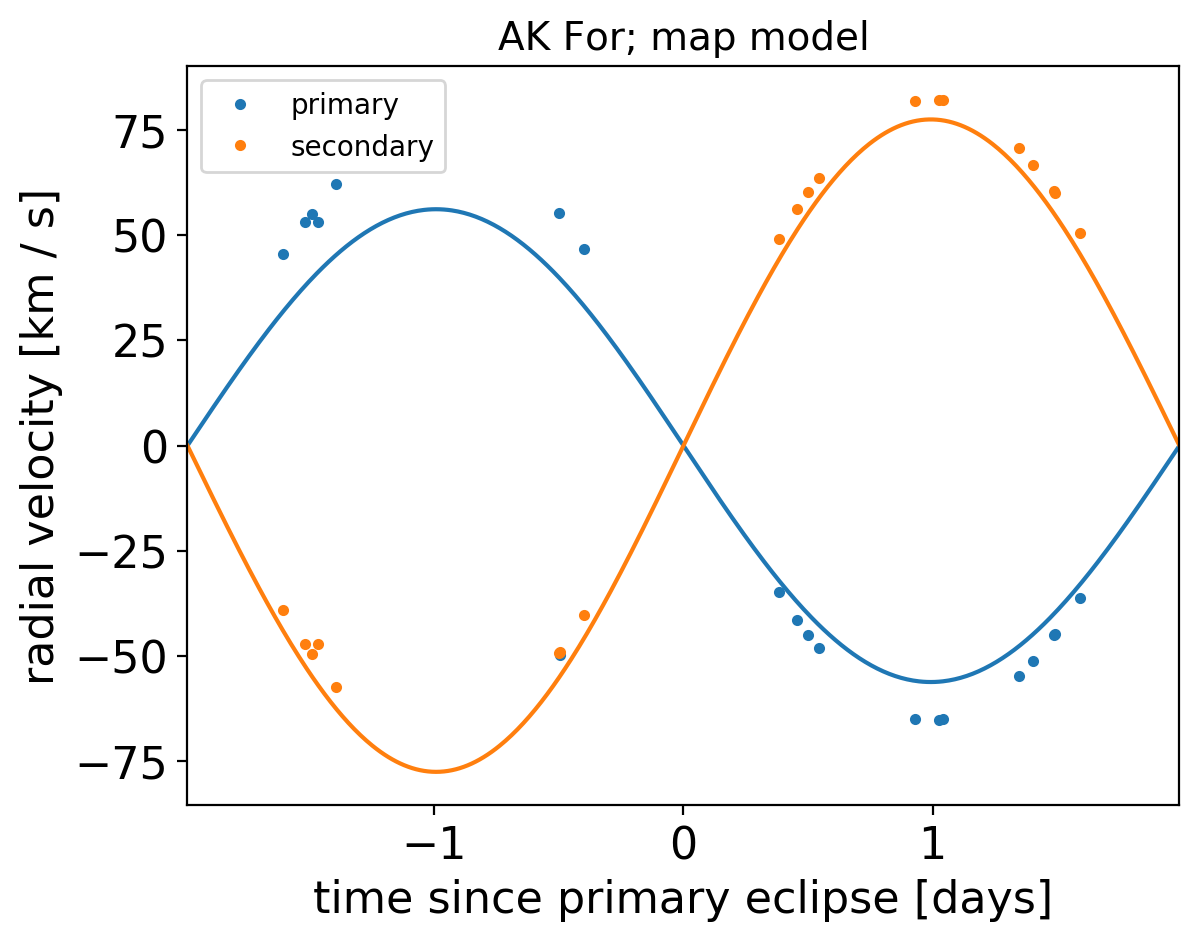

In [10]:
period = map_soln["period"]
t0 = map_soln["t0"]
mean = map_soln["mean_rv"]

x_fold = (x_rv - t0 + 0.5 * period) % period - 0.5 * period
plt.plot(fold, y1_rv - mean, ".", label="primary")
plt.plot(fold, y2_rv - mean, ".", label="secondary")

x_phase = np.linspace(-0.5 * period, 0.5 * period, 500)
with model:
    y1_mod, y2_mod = xo.eval_in_model(
        [model.model_rv1(x_phase + t0), model.model_rv2(x_phase + t0)], map_soln
    )
plt.plot(x_phase, y1_mod - mean, "C0")
plt.plot(x_phase, y2_mod - mean, "C1")

plt.legend(fontsize=10)
plt.xlim(-0.5 * period, 0.5 * period)
plt.ylabel("radial velocity [km / s]")
plt.xlabel("time since primary eclipse [days]")
_ = plt.title("AK For; map model", fontsize=14)

And then the light curve.
In the top panel, we show the Gaussian process model for the phase curve.
It's clear that there's a lot of information there that we could take advantage of, but that's a topic for another day.
In the bottom panel, we're plotting the phase folded light curve and we can see the ridiculous signal to noise that we're getting on the eclipses.

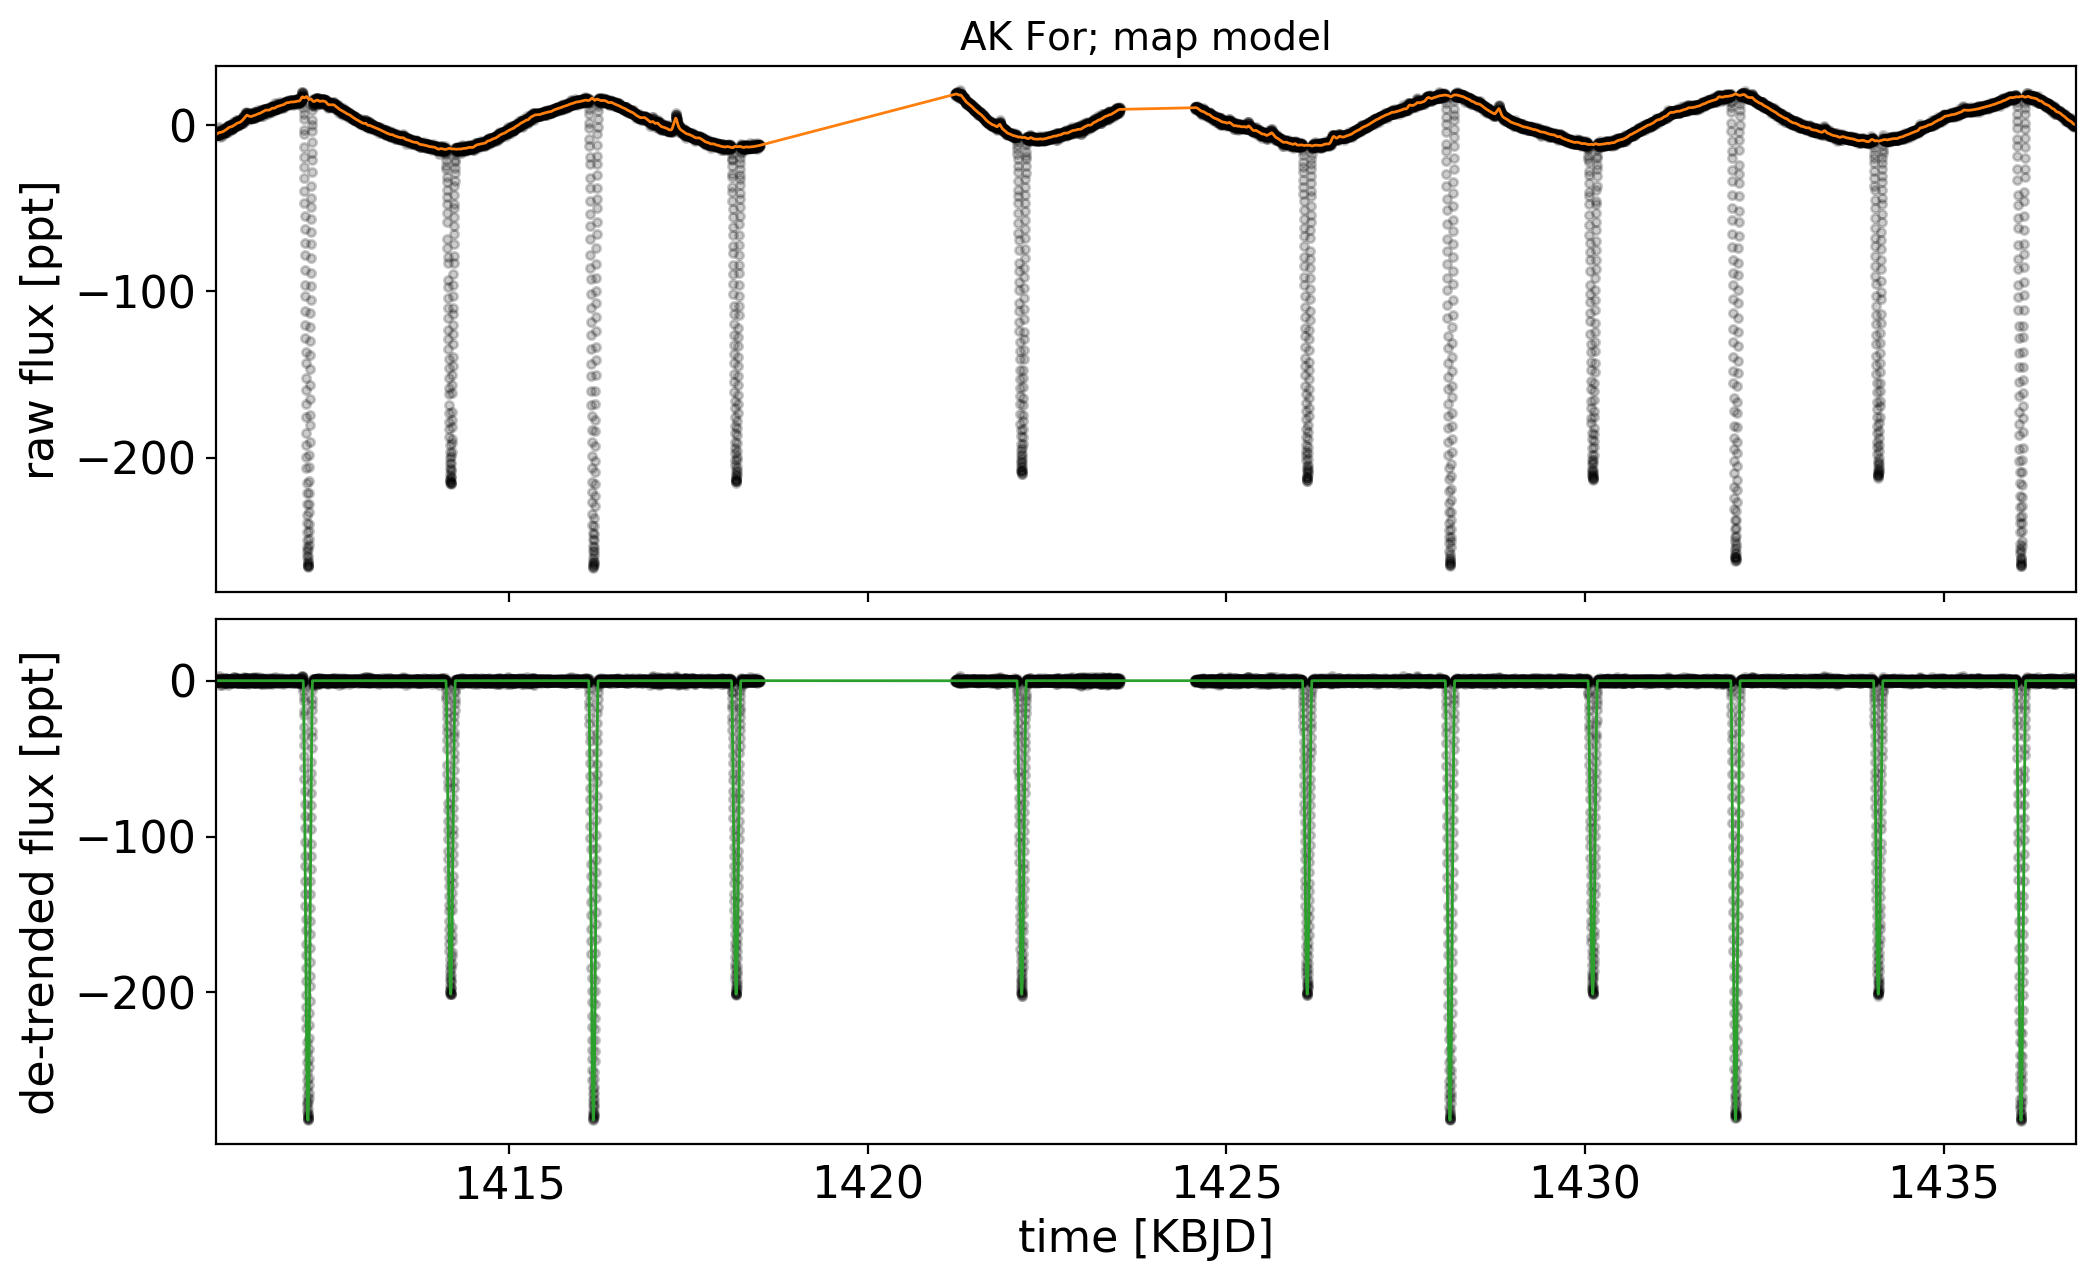

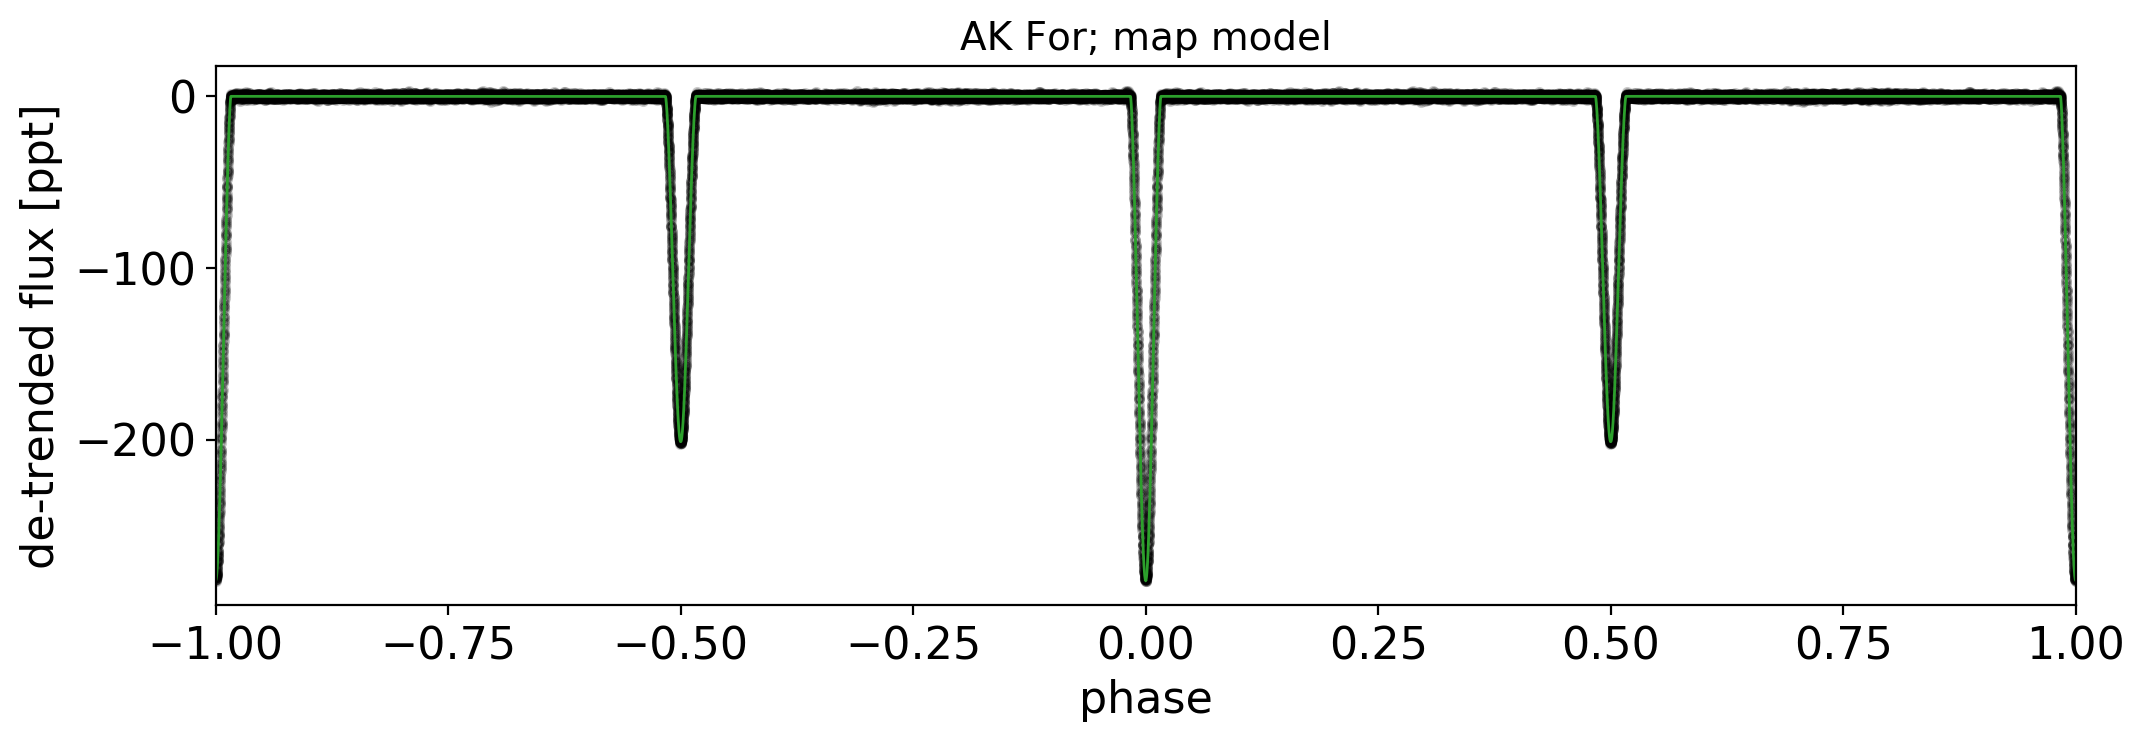

In [11]:
with model:
    gp_pred = xo.eval_in_model(model.gp_lc.predict(), map_soln) + map_soln["mean_lc"]
    lc = xo.eval_in_model(model.model_lc(model.x), map_soln) - map_soln["mean_lc"]

fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(12, 7))

ax1.plot(model.x, model.y, "k.", alpha=0.2)
ax1.plot(model.x, gp_pred, color="C1", lw=1)

ax2.plot(model.x, model.y - gp_pred, "k.", alpha=0.2)
ax2.plot(model.x, lc, color="C2", lw=1)
ax2.set_xlim(model.x.min(), model.x.max())

ax1.set_ylabel("raw flux [ppt]")
ax2.set_ylabel("de-trended flux [ppt]")
ax2.set_xlabel("time [KBJD]")
ax1.set_title("AK For; map model", fontsize=14)

fig.subplots_adjust(hspace=0.05)

fig, ax1 = plt.subplots(1, figsize=(12, 3.5))

x_fold = (model.x - map_soln["t0"]) % map_soln["period"] / map_soln["period"]
inds = np.argsort(x_fold)

ax1.plot(x_fold[inds], model.y[inds] - gp_pred[inds], "k.", alpha=0.2)
ax1.plot(x_fold[inds] - 1, model.y[inds] - gp_pred[inds], "k.", alpha=0.2)
ax2.plot(x_fold[inds], model.y[inds] - gp_pred[inds], "k.", alpha=0.2, label="data!")
ax2.plot(x_fold[inds] - 1, model.y[inds] - gp_pred, "k.", alpha=0.2)

yval = model.y[inds] - gp_pred
bins = np.linspace(0, 1, 75)
num, _ = np.histogram(x_fold[inds], bins, weights=yval)
denom, _ = np.histogram(x_fold[inds], bins)
ax2.plot(0.5 * (bins[:-1] + bins[1:]) - 1, num / denom, ".w")

args = dict(lw=1)

ax1.plot(x_fold[inds], lc[inds], "C2", **args)
ax1.plot(x_fold[inds] - 1, lc[inds], "C2", **args)

ax1.set_xlim(-1, 1)
ax1.set_ylabel("de-trended flux [ppt]")
ax1.set_xlabel("phase")
_ = ax1.set_title("AK For; map model", fontsize=14)

## Sampling

Finally we can run the MCMC:

In [16]:
np.random.seed(23642)
with model:
    trace = xo.sample(
        tune=3500,
        draws=3000,
        start=map_soln,
        chains=4,
        initial_accept=0.8,
        target_accept=0.95,
    )

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ell_rv, S_tot_rv, sigma_rv2, sigma_rv1, ell_lc, S_tot_lc, sigma_lc, ecs, t0, period, b, s, q, k, R1, M1, u2, u1, mean_rv, mean_lc]
Sampling 4 chains, 0 divergences:   1%|          | 182/26000 [02:53<6:50:45,  1.05draws/s] 


ValueError: Not enough samples to build a trace.

As usual, we can check the convergence diagnostics for some of the key parameters.

In [13]:
pm.summary(trace, var_names=["M1", "M2", "R1", "R2", "ecs", "incl", "s"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean   ess_sd  \
M1      2.245  0.028   2.190    2.296      0.000    0.000   11874.0  11874.0   
M2      1.570  0.022   1.525    1.609      0.000    0.000   12149.0  12149.0   
R1      1.759  0.033   1.696    1.820      0.000    0.000    4716.0   4706.0   
R2      1.512  0.052   1.415    1.609      0.001    0.001    4573.0   4573.0   
ecs[0]  0.000  0.000   0.000    0.000      0.000    0.000   16043.0  14987.0   
ecs[1] -0.002  0.005  -0.011    0.006      0.000    0.000    8964.0   6274.0   
incl    1.365  0.002   1.361    1.369      0.000    0.000    4692.0   4690.0   
s       0.478  0.021   0.439    0.517      0.000    0.000    7529.0   7528.0   

        ess_bulk  ess_tail  r_hat  
M1       12144.0    8608.0    1.0  
M2       12742.0    7752.0    1.0  
R1        4755.0    5027.0    1.0  
R2        4638.0    4786.0    1.0  
ecs[0]   16052.0    8366.0    1.0  
ecs[1]    9017.0    8072.0    1.0  
incl      4847.0    4268.0    1.0  
s         7552.0    8168.0    1.0

## Results

It can be useful to take a look at some diagnostic corner plots to see how the sampling went.
First, let's look at some observables:

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.


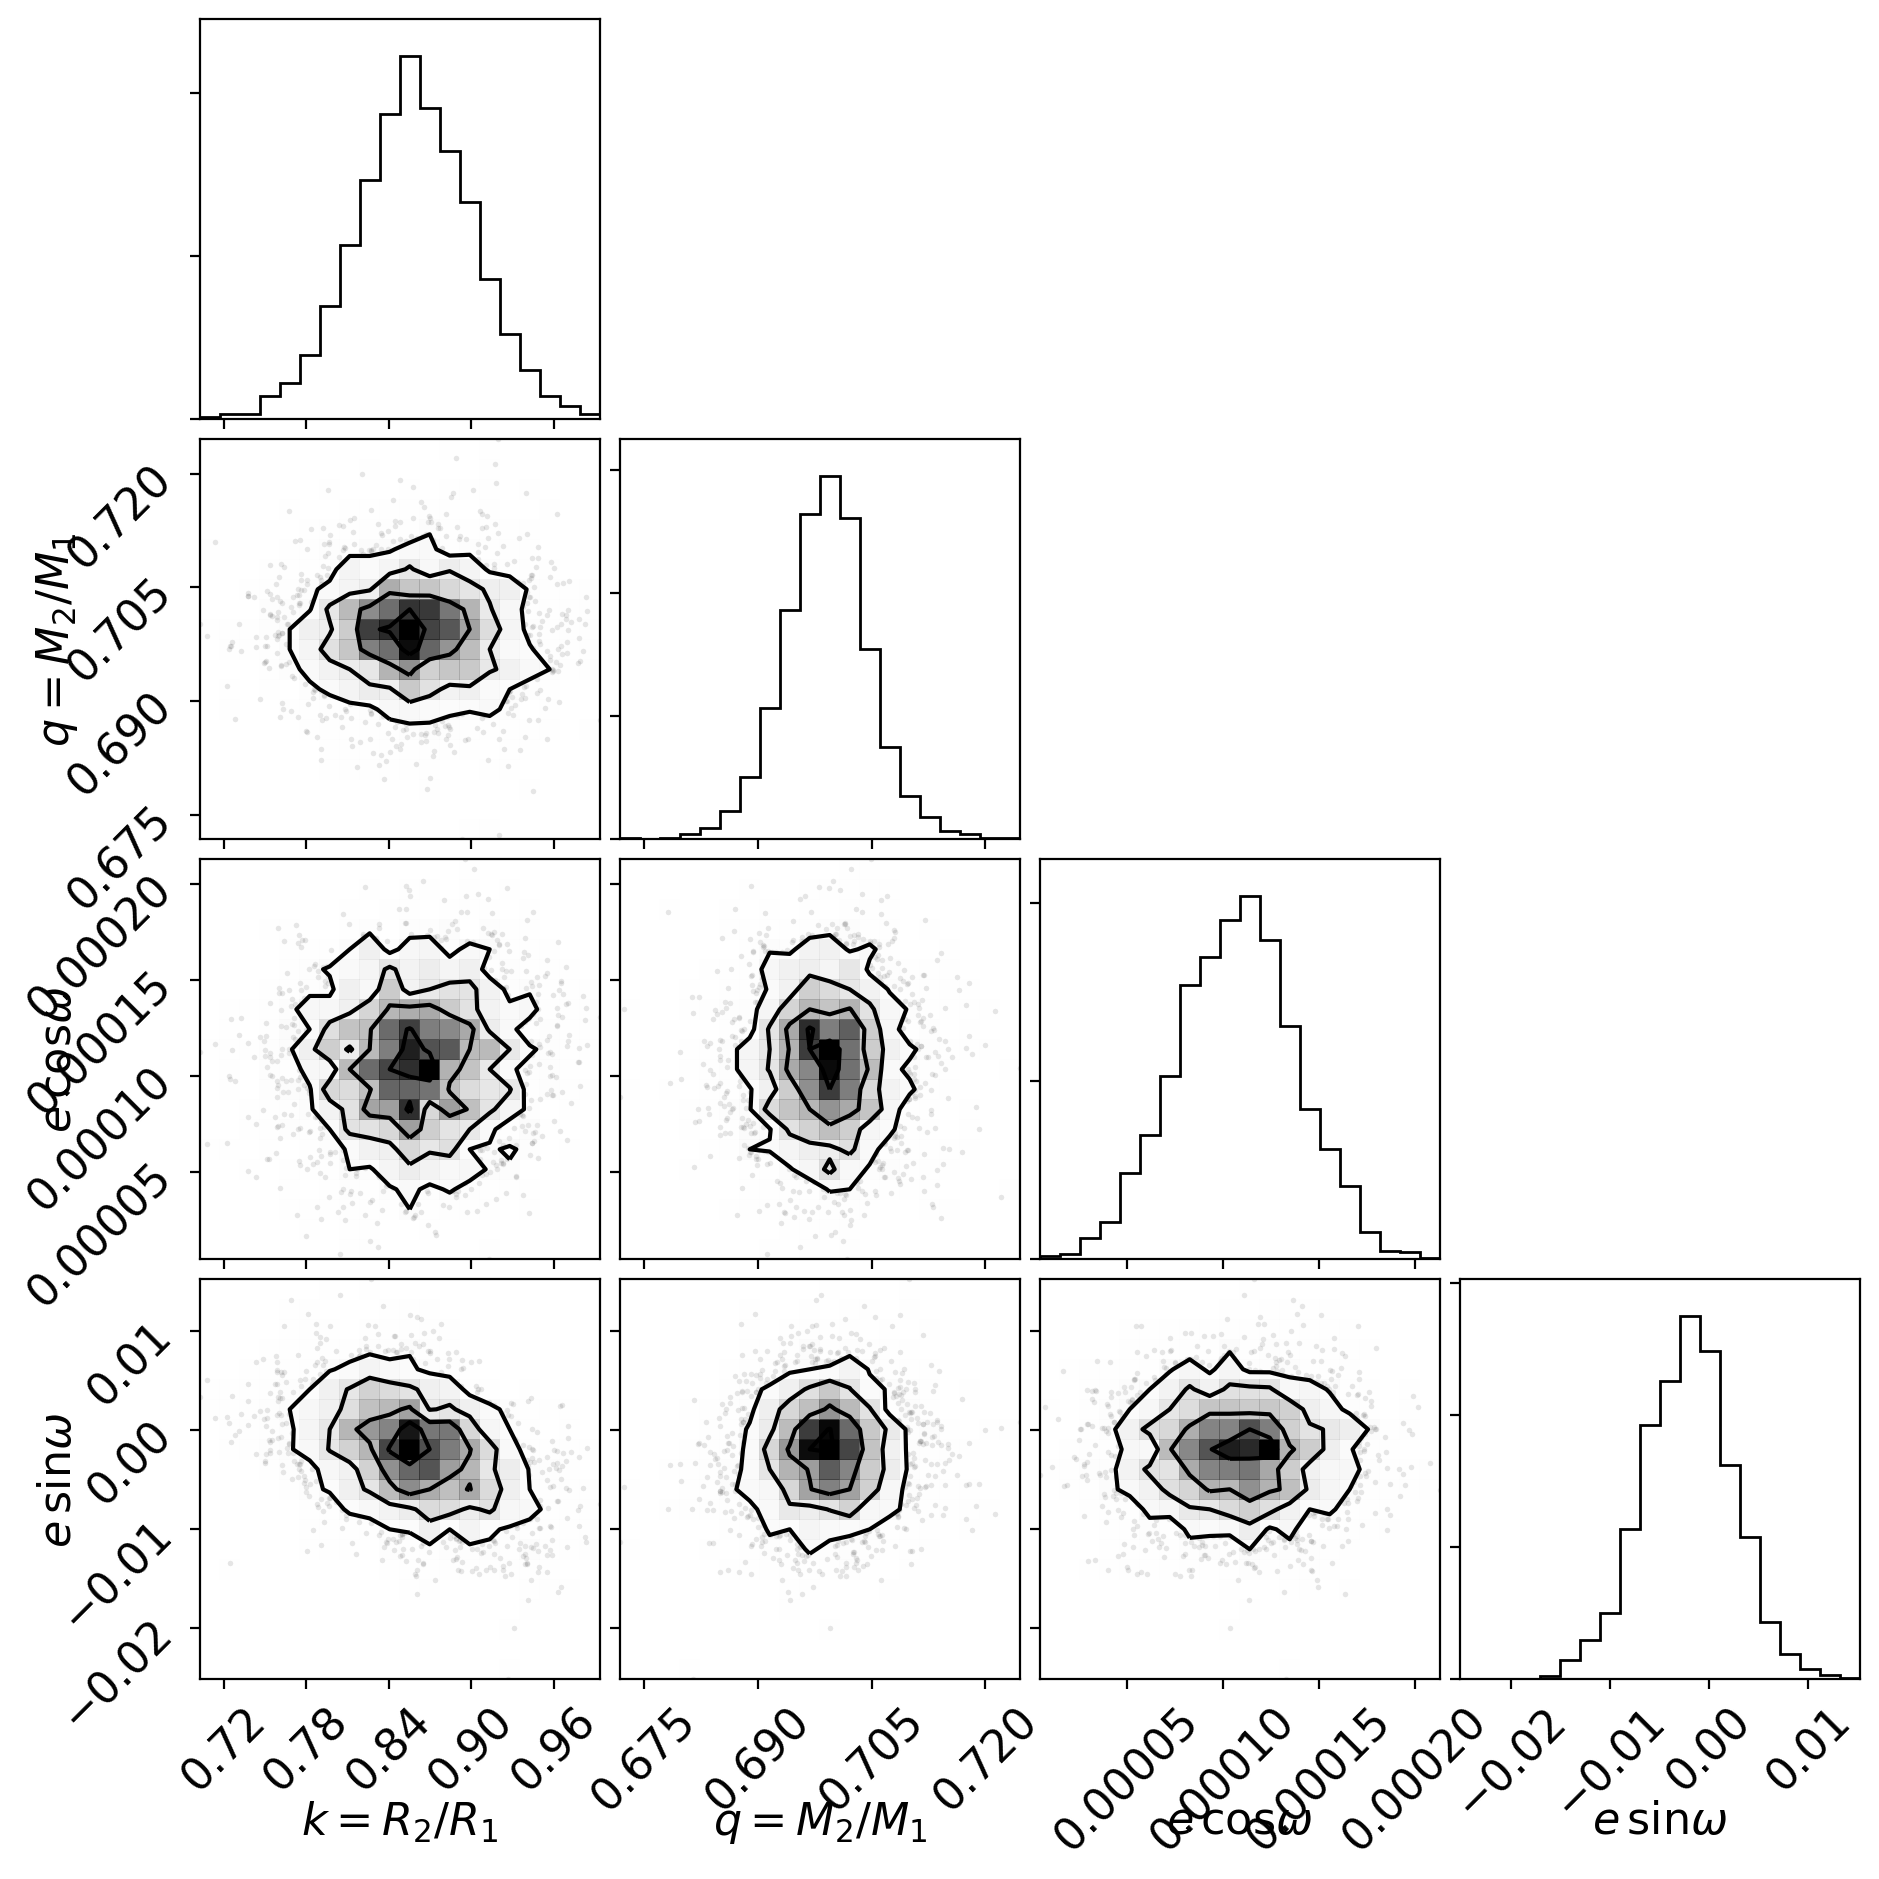

In [19]:
import corner

samples = pm.trace_to_dataframe(trace, varnames=["k", "q", "ecs"])
_ = corner.corner(
    samples,
    labels=["$k = R_2 / R_1$", "$q = M_2 / M_1$", "$e\,\cos\omega$", "$e\,\sin\omega$"],
)

And then we can look at the physical properties of the stars in the system.
In this figure, we're comparing to the results from [David+ (2016)](https://arxiv.org/abs/1602.01901) (shown as blue crosshairs).
The orange contours in this figure show the results transformed to a uniform prior on eccentricity as discussed below.
These contours are provided to demonstrate (qualitatively) that these inferences are not sensitive to the choice of prior.

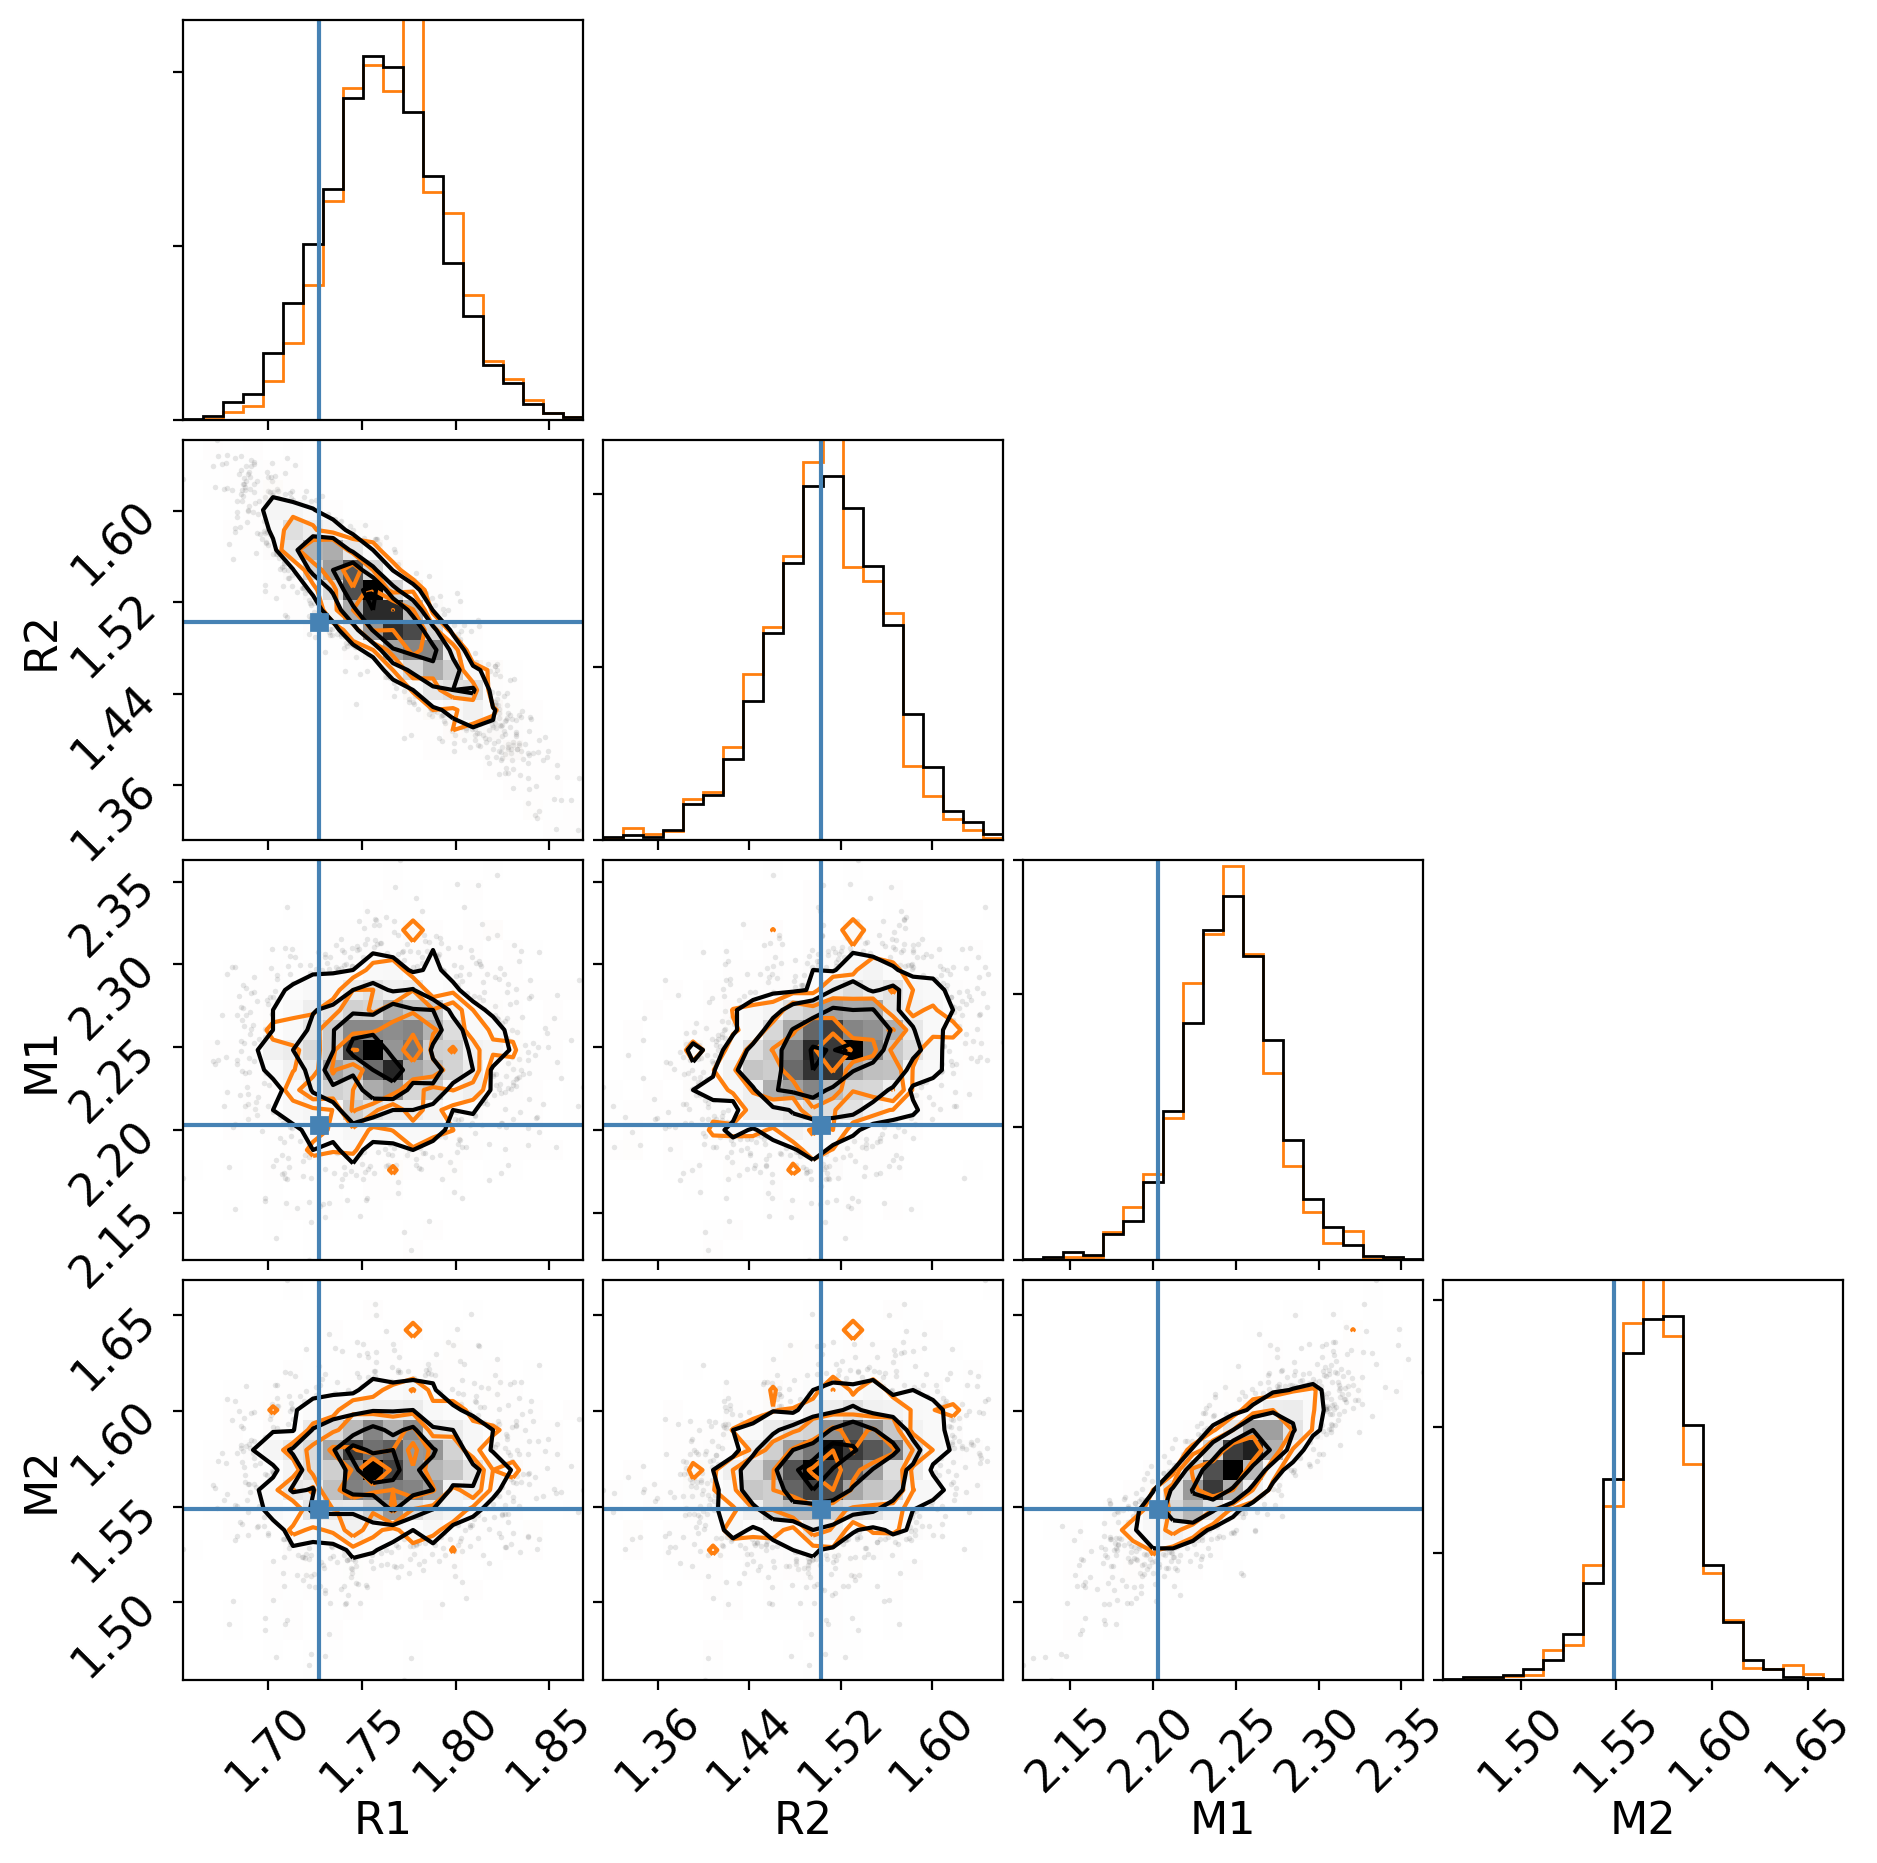

In [20]:
samples = pm.trace_to_dataframe(trace, varnames=["R1", "R2", "M1", "M2"])
weights = 1.0 / trace["ecc"]
weights *= len(weights) / np.sum(weights)
fig = corner.corner(samples, weights=weights, plot_datapoints=False, color="C1")
_ = corner.corner(samples, truths=[1.727, 1.503, 2.203, 1.5488], fig=fig)

## A note about eccentricities

If you looked closely at the model defined above, you might have noticed that we chose a slightly odd eccentricity prior: $p(e) \propto e$.
This is implied by sampling with $e\,\cos\omega$ and $e\,\sin\omega$ as the parameters, as has been discussed many times in the literature.
There are many options for correcting for this prior and instead assuming a uniform prior on eccentricity (for example, sampling with $\sqrt{e}\,\cos\omega$ and $\sqrt{e}\,\sin\omega$ as the parameters), but you'll find much worse sampling performance for this problem if you try any of these options (trust us, we tried!) because the geometry of the posterior surface becomes much less suitable for the sampling algorithm in PyMC3.
Instead, we can re-weight the samples after running the MCMC to see how the results change under the new prior.
Most of the parameter inferences are unaffected by this change (because the data are very constraining!), but the inferred eccentricity (and especially $e\,\sin\omega$) will depend on this choice.
The following plots show how these parameter inferences are affected.
Note, especially, how the shape of the $e\,\sin\omega$ density changes.

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


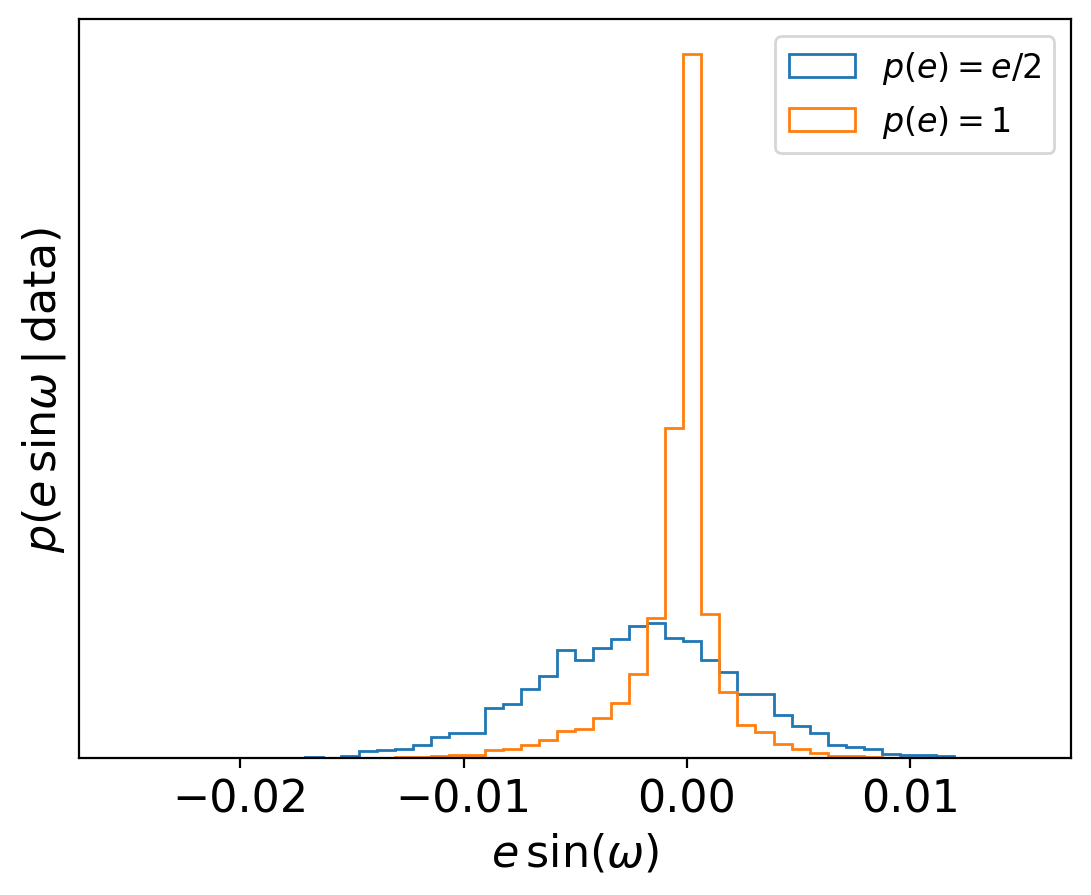

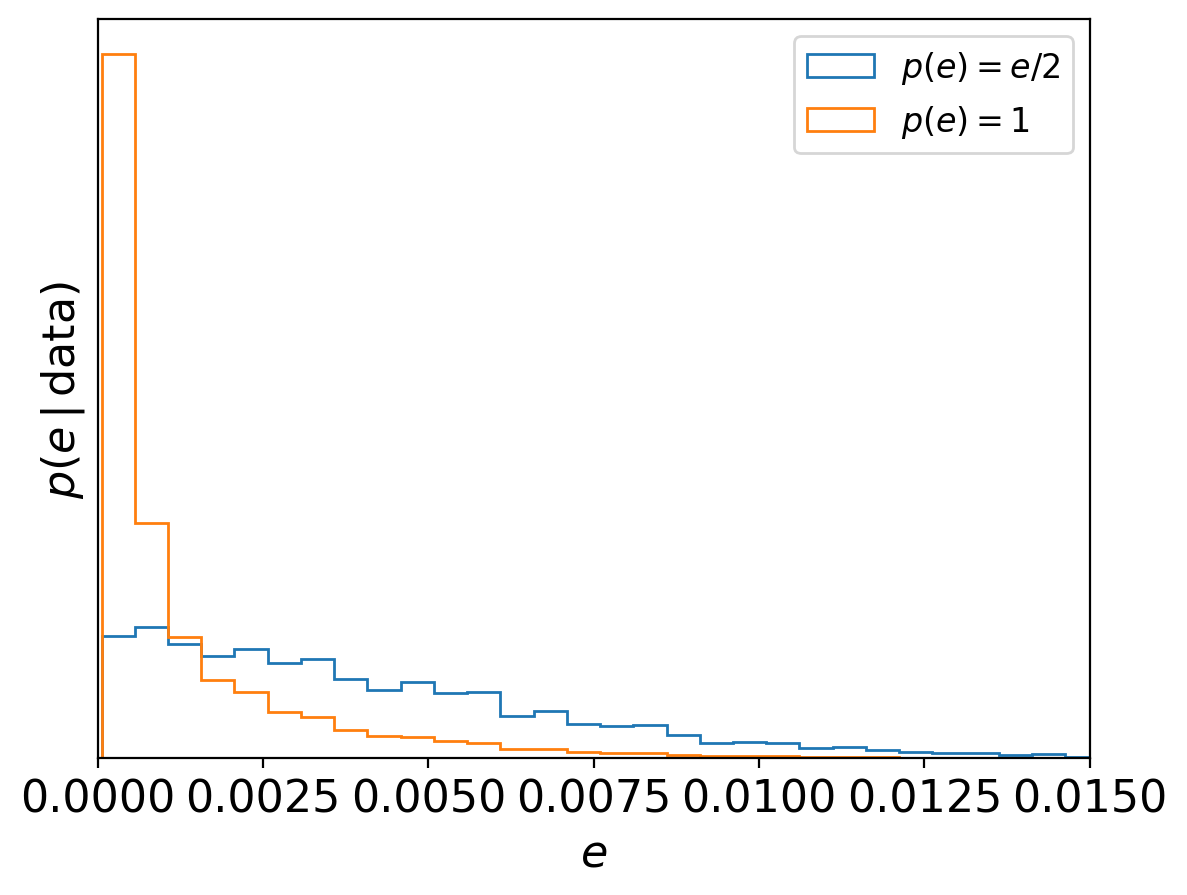

In [21]:
plt.hist(
    trace["ecc"] * np.sin(trace["omega"]),
    50,
    density=True,
    histtype="step",
    label="$p(e) = e / 2$",
)
plt.hist(
    trace["ecc"] * np.sin(trace["omega"]),
    50,
    density=True,
    histtype="step",
    weights=1.0 / trace["ecc"],
    label="$p(e) = 1$",
)
plt.xlabel("$e\,\sin(\omega)$")
plt.ylabel("$p(e\,\sin\omega\,|\,\mathrm{data})$")
plt.yticks([])
plt.legend(fontsize=12)

plt.figure()
plt.hist(trace["ecc"], 50, density=True, histtype="step", label="$p(e) = e / 2$")
plt.hist(
    trace["ecc"],
    50,
    density=True,
    histtype="step",
    weights=1.0 / trace["ecc"],
    label="$p(e) = 1$",
)
plt.xlabel("$e$")
plt.ylabel("$p(e\,|\,\mathrm{data})$")
plt.yticks([])
plt.xlim(0, 0.015)
_ = plt.legend(fontsize=12)

We can then use the `corner.quantile` function to compute summary statistics of the weighted samples as follows.
For example, here how to compute the 90% posterior upper limit for the eccentricity:

In [22]:
weights = 1.0 / trace["ecc"]
print(
    "for p(e) = e/2: p(e < x) = 0.9 -> x = {0:.5f}".format(
        corner.quantile(trace["ecc"], [0.9])[0]
    )
)
print(
    "for p(e) = 1:   p(e < x) = 0.9 -> x = {0:.5f}".format(
        corner.quantile(trace["ecc"], [0.9], weights=weights)[0]
    )
)

for p(e) = e/2: p(e < x) = 0.9 -> x = 0.00839
for p(e) = 1:   p(e < x) = 0.9 -> x = 0.00381


Or, the posterior mean and variance for the radius of the primary:

In [23]:
samples = trace["R1"]

print(
    "for p(e) = e/2: R1 = {0:.3f} ± {1:.3f}".format(np.mean(samples), np.std(samples))
)

mean = np.sum(weights * samples) / np.sum(weights)
sigma = np.sqrt(np.sum(weights * (samples - mean) ** 2) / np.sum(weights))
print("for p(e) = 1:   R1 = {0:.3f} ± {1:.3f}".format(mean, sigma))

for p(e) = e/2: R1 = 1.761 ± 0.031
for p(e) = 1:   R1 = 1.766 ± 0.029


As you can see (and as one would hope) this choice of prior does not significantly change our inference of the primary radius.

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [24]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:agol19, exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:foremanmackey17, exoplanet:foremanmackey18,
exoplanet:kipping13, exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


In [25]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Daniel Foreman-Mackey and Rodrigo Luger and Ian Czekala and
            Eric Agol and Adrian Price-Whelan and Tom Barclay},
   title = {exoplanet-dev/exoplanet v0.3.2},
   month = may,
    year = 2020,
     doi = {10.5281/zenodo.1998447},
     url = {https://doi.org/10.5281/zenodo.1998447}
}
...
